# Dordek et al., (2016) grid cell representations

In this notebook we carry out simple predictions of what grid cells could look like by simulating place cell input to a feedforward model with trajectories generated by RatInABox.

https://elifesciences.org/articles/10094


Final 'goal' figure to reproduce:

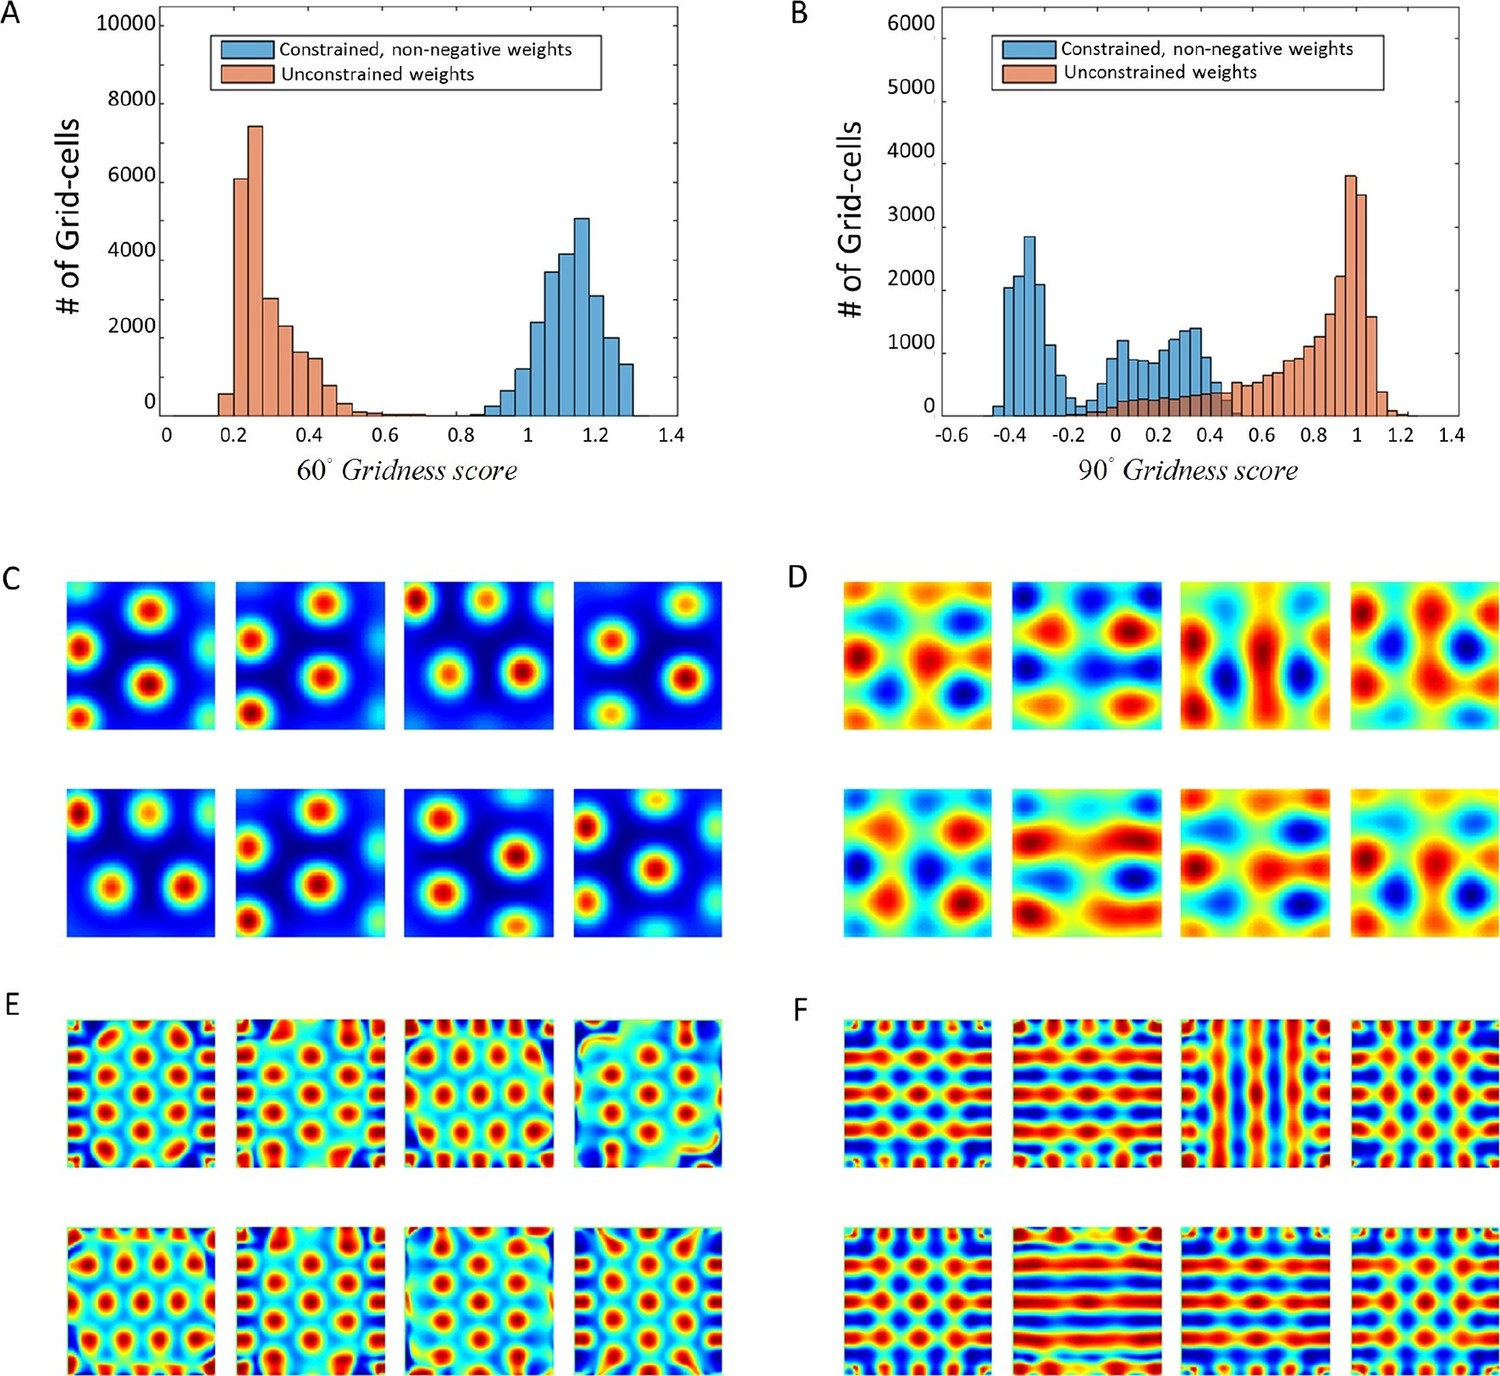

In [68]:
# @title VScode setup

#Main package dependencies
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import ratinabox as riab

#Importing files from Peter Doohan's maze codebase:

import functions.representations as mr
import functions.plotting as mp
#Note that functions and packages e.g. plt and nx will be retrievable under plotting

#Bridging networkX maze representations to RatInABox

import functions.mouse_in_a_maze as miam


# Open Field RatInABox

Below we briefly demonstrate that weights either converge to square or hexagonal grid cell output, depending on non-negativity of weights of a feedforward layer of place cell inputs updated on Oja's (1982) learning rule (performing PCA).
[ugly, but accurate, long sentence]

For each $i$th place cell input, the weights ($W_i^t$) should be updated according to:

$$ \Delta W_i^t = \alpha^t(GC^t\cdot PC_i^t - (GC^t)^2 W_i^t) $$

where, at time $t$, $GC^t$ is the output grid cell activity, and $PC_i^t$ is the input of the $i$th place cell activity.

The activation function $f$ can be specified by rat in a box, either as a sigmoid or RELU, such that the final 'grid cell' output is a feedforward linear sum:

$$ GC^t = f(\sum_{i=1}^n W_i^t\cdot PC^t_i)$$

Thanks to Rat in a box this should be rather straight-forward.


In [165]:
# @title Rat in a box - Setup

#For reproducibility and controlled trajectory generation, we implement seeds:
PC_seed = 2
Trajectory_seed = 2

# Parameters #
n_PCs = 625
n_GCs = 10
PC_size = 0.075
PC_type = 'DOG' #'DOG for difference of gaussians
non_negativity = True #constrain weights to be non-negative?

# Default parameters # 
dt = 1/60 # matching video framerate for update rate

# hidden (secret sauce) parameters #
max_init_weight = 0.04 #
slope = 100 #

# RIAB setup #

np.random.seed(PC_seed) #this seed will determine the 

box = riab.Environment(params={"dimensionality":"2D", "scale":1}) #scaled to 1.38x1.38m as in maze environment

rat = riab.Agent(box, params={"wall_repel_distance": 0.01,
                             "wall_repel_strength": 3,
                             "dt": dt, #60Hz sampling rate (matching video framerate)
                             })
PCs = riab.PlaceCells(rat, params = {"n":n_PCs,
                                    "description":"diff_of_gaussians", #Change to check dependence
                                    "widths":PC_size, #Field size will change grid scale: S=widths*7.54+0.62, according to Dordek et al., 2016
                                    "name":"PlaceCells",
                                  # "max_fr":25, #Removing for diff of gaussians input when output is scaled.
                                  # "min_fr":0 #adding for the tanh activation function
                                    })

#for the feedforwardlayer we consider the following activation functions:
#"activation_function":   {"activation":"linear"} #DEFAULT
#                         {"activation":"tanh", "gain":100, "threshold":0} similar to atan in Dordek et al., 2016;
#                         {"activation":"sigmoid", "max_fr":20, "min_fr":0, "mid_x":1, "width":2}
#                         } #For RELU the gain helps convergence by introducing a slope. This is a hidden Dordek hyperparameter.

GCs = riab.FeedForwardLayer(rat, params={"n":n_GCs,
                                        "input_layers":[PCs],
                                        "name":"GridCells",
                                        #"activation_function":{"activation":"relu", "gain":100}
                                        }
                            )

overlay = riab.GridCells(
    rat,
    params={"n": 10,
            "color": "C2",
            "description": "three_shifted_cosines", #Solstad et al. 2006 equation 2
            "gridscale_distribution":'modules',
            "gridscale":(0.35, 0.5, 0.71)},
)

#scale the weights so they aren't "too big" to begin with; another Dordek et al., 2016 hack from out of the blue.
#rescaled = max_init_weight*(GCs.inputs['PlaceCells']['w_init'])/np.max(GCs.inputs['PlaceCells']['w_init'])
#GCs.inputs['PlaceCells']['w_init'] = rescaled

(<Figure size 414x414 with 1 Axes>, <Axes: >)

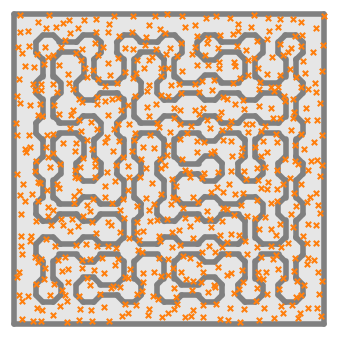

In [39]:
PCs.plot_place_cell_locations()

Oja's learning rule implementation

In [126]:
# @title Oja's rule implementation

## Function to update the weight according to Oja's learning rule
# Based off of path_integration_example demo from Rat in a box.


#Do not ask why: implementing a slope as in Dordek et al. will lead to gridness.
#Here we just make sure to remove this
if GCs.params['activation_function']['activation']!='linear':
  slope = 1

def weight_change(GCs, non_negativity):
  #To implement Oja's rule we need current GC firing rate, place cell input, and learning rate at time t.
  GC_rates = slope*GCs.firingrate #note the slope.
  PC_rates = np.tile(GCs.inputs['PlaceCells']['I'], (n_GCs,1)) #take current place cell input. Must be tiled to the number of grid cells.
  w = GCs.inputs['PlaceCells']['w'] #take current weights

  #For learning rate, Dordek et al. implement a decay.
  t = GCs.history['t'][-1]*dt #take most recent timepoint, scale it by dt so t is in increments of steps (referred to as tind in Dordek code).
  alpha = 1/(t+1e5) #as documented in Dordek et al. paper.

  #Oja's rule:
  dw = alpha*(GC_rates[:,np.newaxis]*PC_rates-(GC_rates[:,np.newaxis]**2)*w) #new-axis trick allows entry-wise multiplication across rows when there's more than one grid cell.
  #if non_negativity == True: #change the update value for all negative values in w so they become 0.
  negative_weights = np.where(w < 0)
  dw[negative_weights] = -1*w[negative_weights]
  
  return dw

In [29]:
# @title Run, rat, run!

np.random.seed(2024)

from tqdm import tqdm

rat.pos = [0.15,0.15] #intialise position inside the maze. Equivalent to maze starting position.
explore_time = 8*40*60 #time in seconds, turns into timesteps when scaled by a factor of Ag.dt

for i in (tqdm(range(int(explore_time/rat.dt)))):
    rat.update()
    PCs.update()
    GCs.update()
    GCs.inputs['PlaceCells']['w'] += weight_change(GCs, non_negativity) #update the weights
    if i == (explore_time/2)/rat.dt:
        half_time_w = GCs.inputs['PlaceCells']['w'].copy()

  1%|          | 9657/1152000 [00:09<18:06, 1051.82it/s]


KeyboardInterrupt: 

In [49]:
#Quick check that 'some' learning has happened
print(np.max(GCs.inputs['PlaceCells']['w_init']))
print(np.max(GCs.inputs['PlaceCells']['w']))
print(np.min(GCs.inputs['PlaceCells']['w_init']))
print(np.min(GCs.inputs['PlaceCells']['w']))

0.17049400746289645
0.17049400746289645
-0.15197380385486048
0.0


## Plotting

First, we plot the weights onto the place cell centres to see whether any pattern shows up.

However, we almost definitely want to demonstrate that these patterns show up in spike plots.

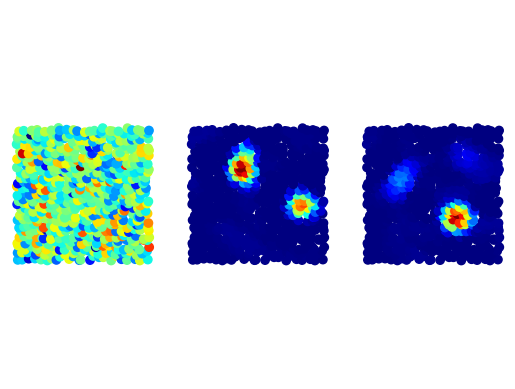

In [48]:
#Plotting weights back onto place cell space.

cell_index = 1 #Index out a grid cell and plot before and after weights

fig, axs = plt.subplots()
axs.axis('off')

ax1 = fig.add_subplot(1,3,1)
ax1.set_aspect('equal')
ax1.axis('off')

init_weights = GCs.inputs['PlaceCells']['w_init'][cell_index]
ax1.scatter(x=PCs.place_cell_centres[:,0],
            y=PCs.place_cell_centres[:,1],
            c=init_weights,
            cmap = "jet")

ax2 = fig.add_subplot(1,3,2)
ax2.set_aspect('equal')
ax2.axis('off')

ax2.scatter(x=PCs.place_cell_centres[:,0],
            y=PCs.place_cell_centres[:,1],
            c=half_time_w[cell_index],
            cmap = "jet")

ax2 = fig.add_subplot(1,3,3)
ax2.set_aspect('equal')
ax2.axis('off')

weights = GCs.inputs['PlaceCells']['w'][cell_index]

ax2.scatter(x=PCs.place_cell_centres[:,0],
            y=PCs.place_cell_centres[:,1],
            c=weights,
            cmap = "jet")


In [24]:
#First 20 minutes of exploration

plot_end_time = 20*60

rat.plot_trajectory(t_start=0, t_end =plot_end_time, alpha=0.2, color='changing')
PCs.plot_rate_map(method='history',  t_start = 0, t_end = plot_end_time )
GCs.plot_rate_map(method='neither', spikes = True, t_start = 0, t_end = plot_end_time)


IndexError: index 0 is out of bounds for axis 0 with size 0

(<Figure size 3000x300 with 20 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

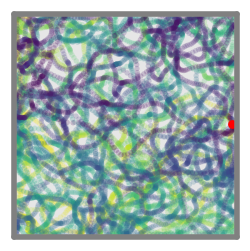

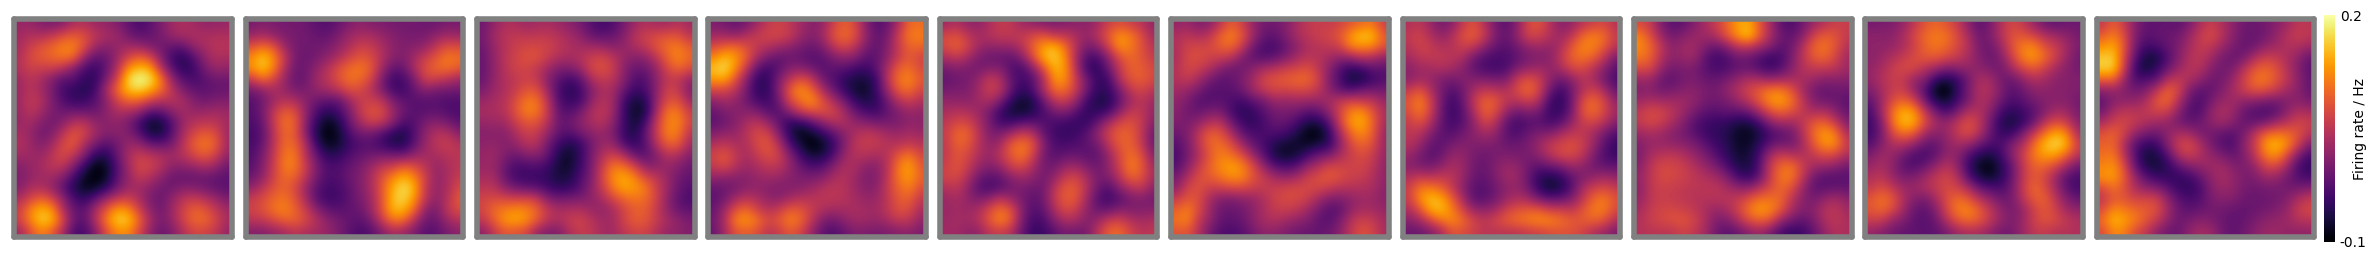

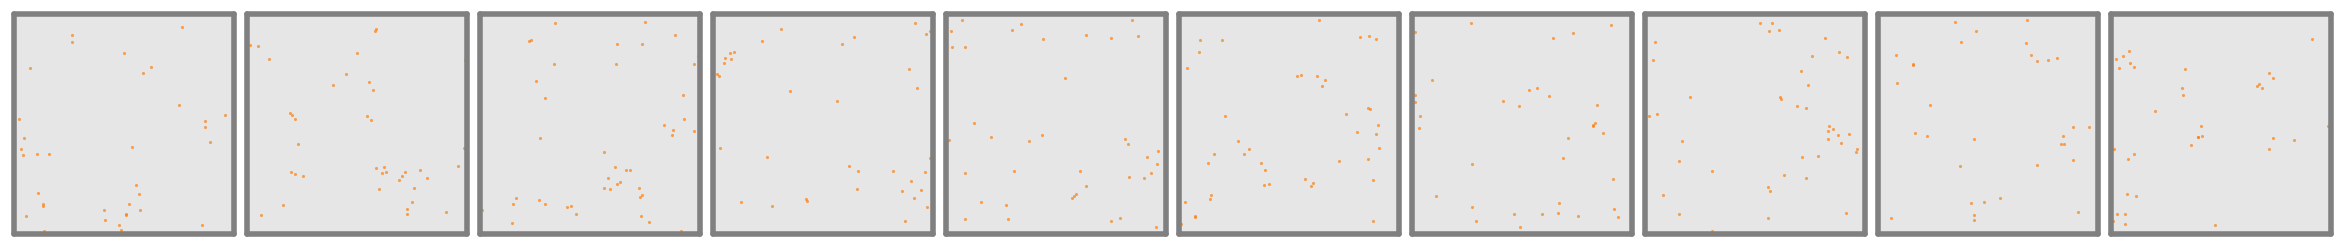

In [24]:
#Last 20 minutes of exploration

plot_start_time = rat.t-20*60

rat.plot_trajectory(t_start=plot_start_time, color="changing", alpha=0.2)
GCs.plot_rate_map(method='history', t_start = plot_start_time)
GCs.plot_rate_map(method='neither', spikes = True, t_start = plot_start_time)

# Mouse in a maze implementation

We've written a script to turn a maze into a rat in a box environment.

'geodesic' wall geometry only supported for enivironments with 1 additional wall (4 bounding walls + 1 additional). Sorry. Using 'line_of_sight' instead.


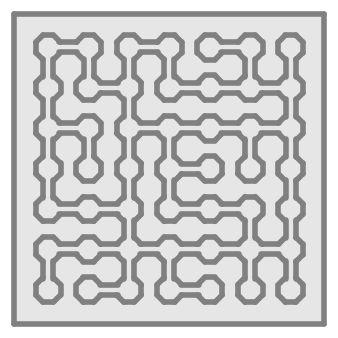

In [166]:
maze_idx = '1' #can be FC, 1, 2, or HP
maze = mr.get_simple_maze(maze_idx)
maze_fine = mr.get_extended_simple_maze(maze) #we need the finer-scale for plotting heatmaps in either case.

env = miam.get_maze_env_walls(maze)
env.plot_environment()

mouse = riab.Agent(env, params={"wall_repel_distance": 0.01,
                             "wall_repel_strength": 3,
                             "dt": 1/60, #60Hz sampling rate (matching video framerate)
                             })
PCs = riab.PlaceCells(mouse, params = {"n":n_PCs,
                                    "description":"diff_of_gaussians", #Change to check dependence
                                    "widths":0.075, #Field size will change grid scale: S=widths*7.54+0.62, according to Dordek et al., 2016
                                    "name":"PlaceCells",
                                  # "max_fr":25, #Removing for diff of gaussians input when output is scaled.
                                  # "min_fr":0 #adding for the tanh activation function
                                    })

#for the feedforwardlayer we consider the following activation functions:
#"activation_function":   {"activation":"linear"} #DEFAULT
#                         {"activation":"tanh", "gain":100, "threshold":0} similar to atan in Dordek et al., 2016;
#                         {"activation":"sigmoid", "max_fr":20, "min_fr":0, "mid_x":1, "width":2}
#                         "activation_function":{"activation":"relu", "gain":100} #For RELU the gain helps convergence by introducing a slope. This is a hidden Dordek hyperparameter.

GCs = riab.FeedForwardLayer(mouse, params={"n":n_GCs,
                                        "input_layers":[PCs],
                                        "name":"GridCells",
                                        "activation":"linear",
                                        }
                            )

In [167]:
## generate / import trajectory ##

np.random.seed(Trajectory_seed)

from tqdm import tqdm

mouse.pos = [0.15,0.15] #intialise position inside the maze.
explore_time = 8*40*60 #time in seconds

for i in (tqdm(range(int(explore_time/mouse.dt)))): 
    mouse.update()
    PCs.update()
    #GCs.update()
    #GCs.inputs['PlaceCells']['w'] += weight_change(GCs, non_negativity) #update the weights
    #if i == (explore_time/2)/rat.dt:
    #  half_time_w = GCs.inputs['PlaceCells']['w'].copy()


## save trajectory ##

#it'll have a crap name, because it needs to know whether 
#   1) what maze it is
#   2) min
#   3) n_PCs
#   4) PC_size
#   5) PC_seed
#   6) TJ_seed

trajectory_data = pd.DataFrame(mouse.history).merge(pd.DataFrame(PCs.history))

trajectory_directory = 'C:/Users/cburns/Documents/Research/maze_grid_cells/data/trajectories'
file_name = trajectory_directory + '/maze_'+str(maze_idx) +'_'+ str(explore_time/60) + '_min_' + str(n_PCs)+str(PC_type)+'_PCs_size_'+str(PC_size)+'_seed_'+str(PC_seed)+'_TJ_seed_'+str(Trajectory_seed) +'.json'

trajectory_data.to_json(file_name, index=False)

  0%|          | 3/1152000 [00:00<12:01:00, 26.63it/s]

 31%|███▏      | 360700/1152000 [2:50:05<6:13:08, 35.34it/s] 


KeyboardInterrupt: 

In [168]:
## load trajectory ##
explore_time = 8*40*60
trajectory_directory = 'C:/Users/cburns/Documents/Research/maze_grid_cells/data/trajectories'
file_name = trajectory_directory + '/maze_'+str(maze_idx) +'_'+ str(explore_time/60) + '_min_' + str(n_PCs)+str(PC_type)+'_PCs_size_'+str(PC_size)+'_seed_'+str(PC_seed)+'_TJ_seed_'+str(Trajectory_seed) +'.json'
#file_name = trajectory_directory + '/open_field_' + str(explore_time/60) + '_min_' + str(n_PCs)+str(PC_type)+'_PCs_size_'+str(PC_size)+'_seed_'+str(PC_seed)+'_TJ_seed_'+str(Trajectory_seed) +'.json'

imported_data = pd.read_json('file_name')

C:\Users\cburns\AppData\Local\Temp\ipykernel_27428\2303914269.py:7: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  imported_data = pd.read_json('file_name')


ValueError: Unexpected character found when decoding 'false'

Run GC learning

In [169]:
from tqdm import tqdm
explore_time = 8*40*60
#note, 1,152,000 iterations took 10 minutes
for i in (tqdm(range(int(explore_time/mouse.dt)))):
    mouse.dt = imported_data['t'][i]
    mouse.pos = imported_data['pos'][i]
    PCs.firingrate = imported_data['firingrate'][i]
    GCs.update()
    GCs.inputs['PlaceCells']['w'] += weight_change(GCs,non_negativity) #update the weights
    if i == (explore_time/2)/rat.dt:
        half_time_w = GCs.inputs['PlaceCells']['w'].copy()

 33%|███▎      | 379176/1152000 [01:25<02:54, 4427.06it/s]


KeyboardInterrupt: 

In [170]:
#Quick check that 'some' learning has happened
print(np.max(GCs.inputs['PlaceCells']['w_init']))
print(np.max(GCs.inputs['PlaceCells']['w']))
print(np.min(GCs.inputs['PlaceCells']['w_init']))
print(np.min(GCs.inputs['PlaceCells']['w']))

0.1482421760843024
0.03253397725726481
-0.15841509168737916
-9.58596721623964e-09


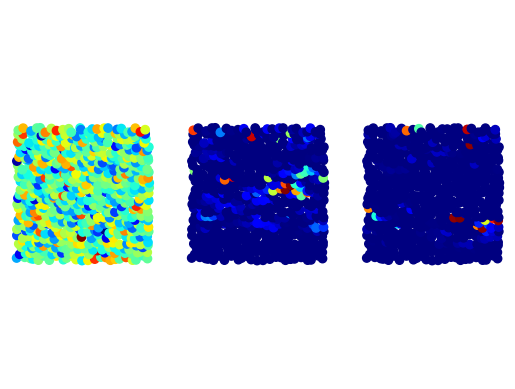

In [171]:
#Plotting weights back onto place cell space.

cell_index = 4 #Index out a grid cell and plot before and after weights

fig, axs = plt.subplots()
axs.axis('off')

ax1 = fig.add_subplot(1,3,1)
ax1.set_aspect('equal')
ax1.axis('off')

init_weights = GCs.inputs['PlaceCells']['w_init'][cell_index]
ax1.scatter(x=PCs.place_cell_centres[:,0],
            y=PCs.place_cell_centres[:,1],
            c=init_weights,
            cmap = "jet")

ax2 = fig.add_subplot(1,3,2)
ax2.set_aspect('equal')
ax2.axis('off')

ax2.scatter(x=PCs.place_cell_centres[:,0],
            y=PCs.place_cell_centres[:,1],
            c=half_time_w[cell_index],
            cmap = "jet")

ax2 = fig.add_subplot(1,3,3)
ax2.set_aspect('equal')
ax2.axis('off')

weights = GCs.inputs['PlaceCells']['w'][cell_index]

ax2.scatter(x=PCs.place_cell_centres[:,0],
            y=PCs.place_cell_centres[:,1],
            c=weights,
            cmap = "jet")


In [172]:
mouse.history['t']= list(imported_data['t'].values)

mouse.history['pos']=list(imported_data['pos'].values)

mouse.history['head_direction'] = list(imported_data['head_direction'].values)

mouse.history['rot_vel'] = list(imported_data['rot_vel'].values)

PCs.history['firingrate'] = list(imported_data['firingrate'].values)

PCs.history['t'] = imported_data['t'].values

(<Figure size 414x414 with 1 Axes>, <Axes: >)

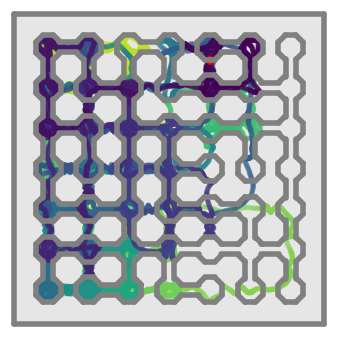

In [173]:
plot_end_time = 20*60

mouse.plot_trajectory(t_start=0, t_end=plot_end_time, alpha=0.2, color='changing')

(<Figure size 4140x414 with 20 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

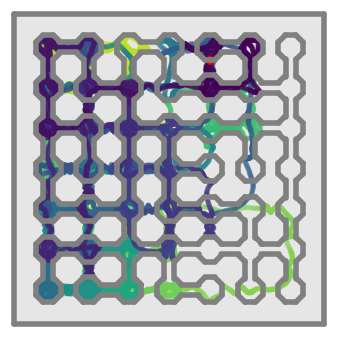

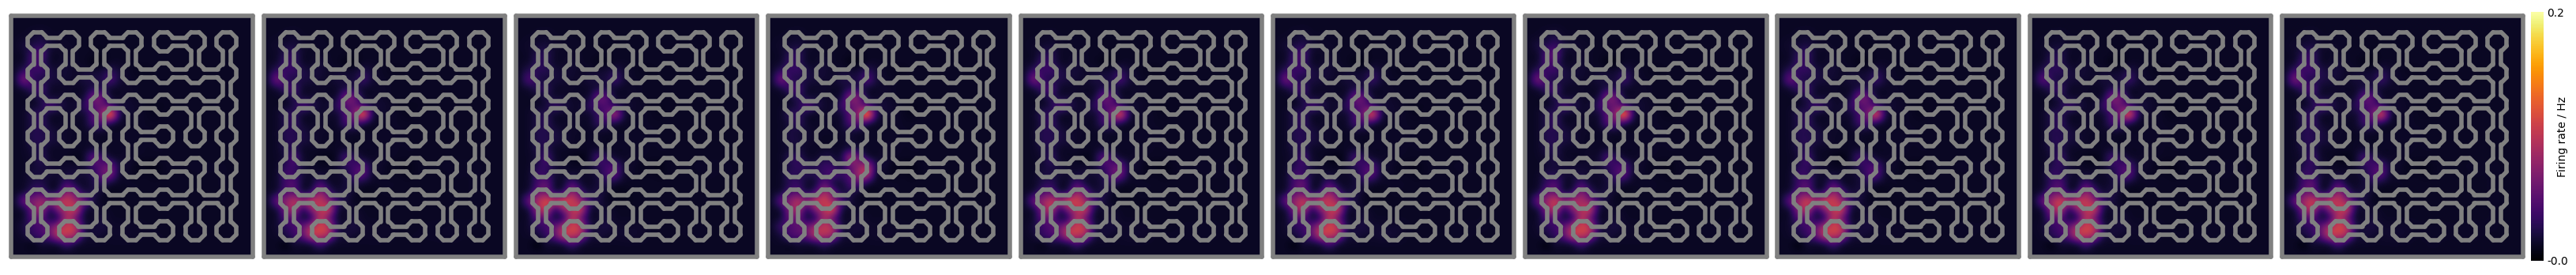

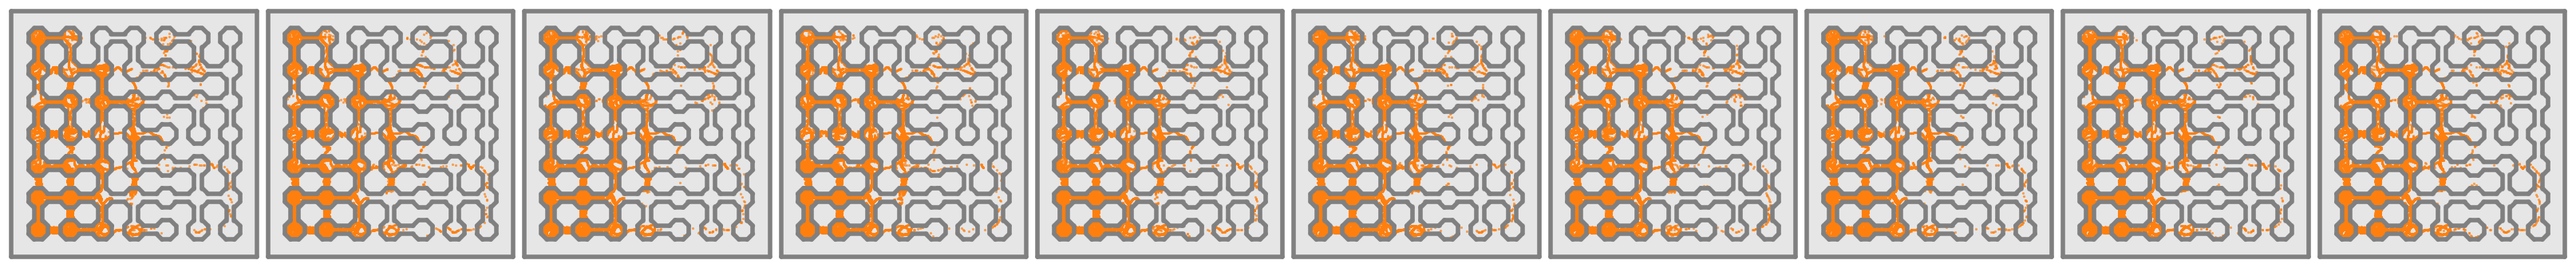

In [174]:
#First 20 minutes of exploration

plot_end_time = 20*60

mouse.plot_trajectory(t_start=0, t_end=plot_end_time, alpha=0.2, color='changing')
GCs.plot_rate_map(method='history',  t_start = 0, t_end = plot_end_time )
GCs.plot_rate_map(method='neither', spikes = True, t_start = 0, t_end = plot_end_time)


(<Figure size 4140x414 with 20 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

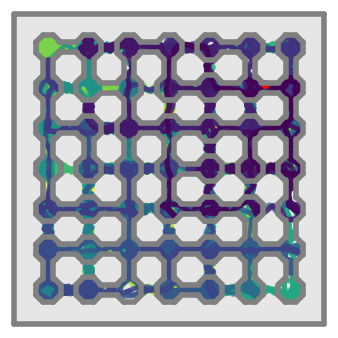

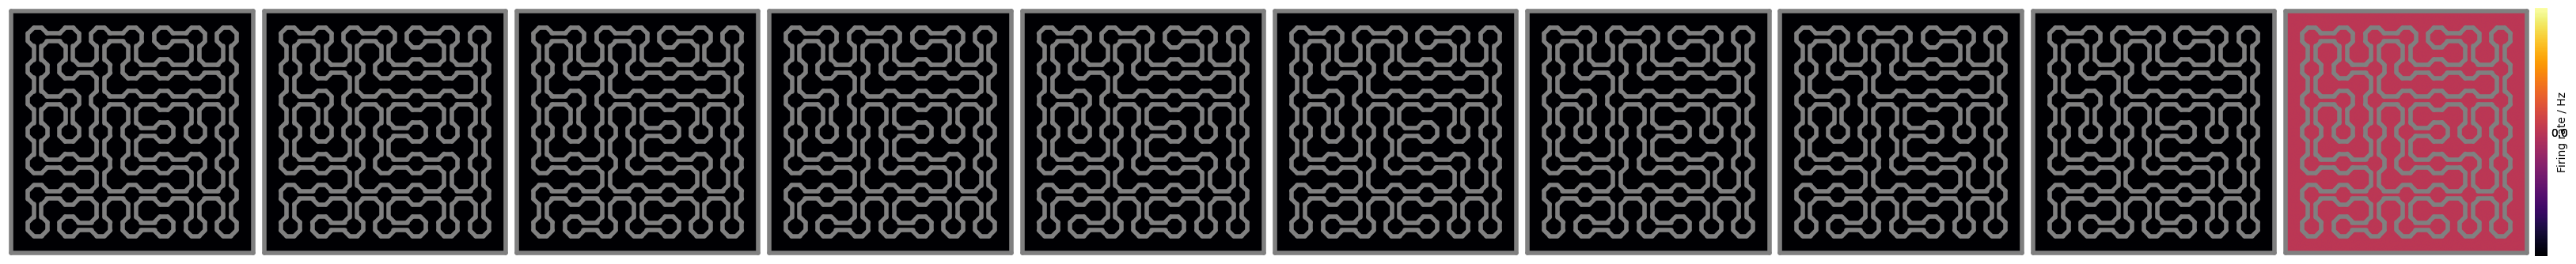

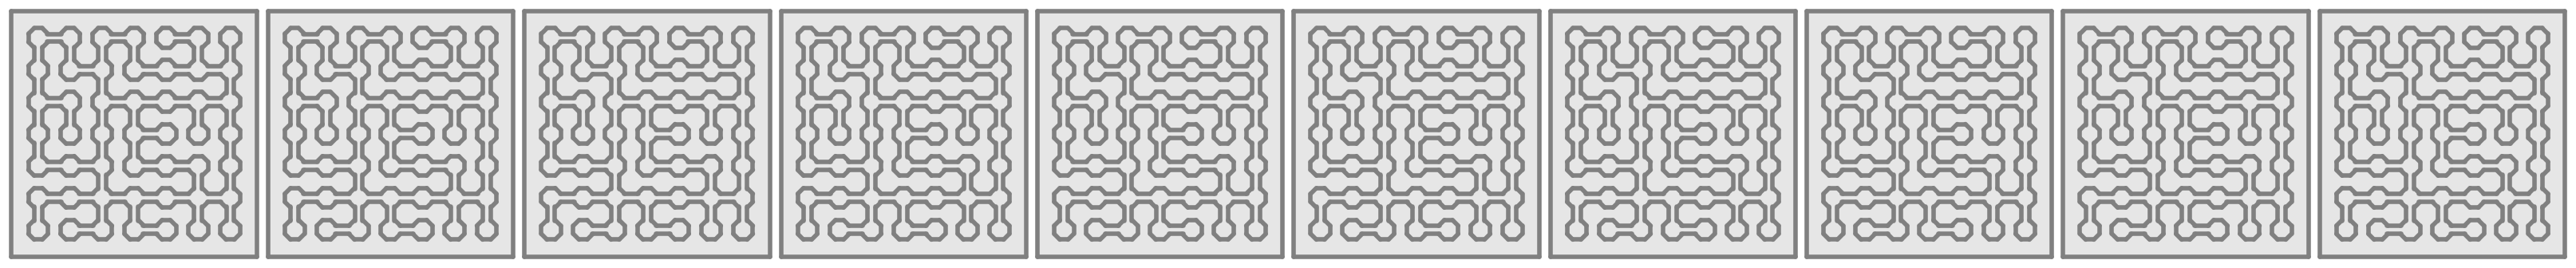

In [175]:
#Last 40 minutes of exploration

plot_start_time = explore_time-40*60

mouse.plot_trajectory(t_start=plot_start_time, color="changing", alpha=0.2)
GCs.plot_rate_map(method='history',  t_start = plot_start_time)
GCs.plot_rate_map(method='neither', spikes = True, t_start = plot_start_time)



## Plotting onto Peter's heatmaps

First with centre firing rate

In [83]:
GCs.get_state

<bound method FeedForwardLayer.get_state of <ratinabox.Neurons.FeedForwardLayer object at 0x000001AC034F0830>>

findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.


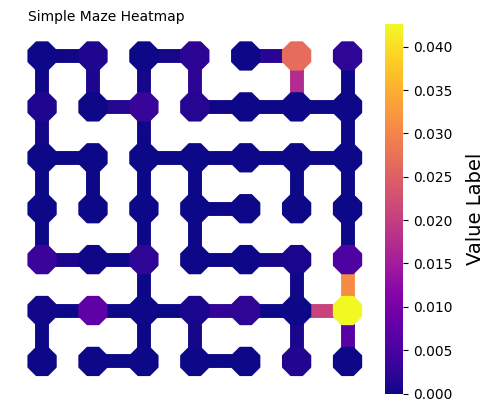

In [176]:
#points = sampling.sample_maze_points(maze, 1000)

centres = mp.nx.get_node_attributes(maze_fine,'position').values()

firingRate = GCs.get_state(evaluate_at='none', pos=np.array(list(centres)))

label = mp.nx.get_node_attributes(maze_fine,'label').values()

values = mp.pd.Series(data=firingRate[5], index=label)
values.index.name='maze_position' #Further required for the plot function to work

fig, ax = mp.plt.subplots()
ax.axis('off')

mp.plot_simple_heatmap(maze, values, ax)

#test = env.sample_positions(n=1000)
#x,y = zip(*test)
#mp.plt.scatter(x, y)

We also want to take the average firing rate within each tower or bridge.
I wonder if Peter has code for that.

He does. The trick is to map the firing rate at a set of coordinates to the nearest neighbour (node or edge centre).

In [ ]:
Agent_data = pd.DataFrame(Ag.history)
Grid_cell_data = pd.DataFrame(GCs.history)

data = pd.merge(Agent_data,Grid_cell_data) #merges by shared columns (t)

#Nearest neighbour from https://stackoverflow.com/questions/57129448/find-distance-to-nearest-neighbor-in-2d-array

from scipy.spatial.distance import cdist

def nearest_neighbour_pos(agent_positions,maze_positions):
  #INPUT:
    dists = cdist(agent_positions,maze_positions)
    nn_dist = np.sort(dists)[0]
    return nn_dist



NameError: name 'Ag' is not defined

In [ ]:
#Using Peter's functions:

from scipy.spatial import KDTree

def get_position2simple_coord_dict(simple_maze):
    """Get a dictionary mapping maze node/edge positions to maze node/edge coordinates"""
    position2simple_node = {tuple(position):node for node, position in simple_maze.nodes(data='position')}
    position2simple_edge={tuple(position):(node1, node2) for node1,node2,position in simple_maze.edges(data='position')}
    position2simple_coord = position2simple_node.copy(); position2simple_coord.update(position2simple_edge)
    return position2simple_coord

def get_nearest_simple_coord(centroid_positions, maze):
    """Get the nearest maze node for each position in the centroid_positions array."""
    position2maze_coord = get_position2simple_coord_dict(maze)
    coord_positions = list(position2maze_coord.keys())
    kd_tree = KDTree(coord_positions) #Create a KDTree from the maze coord positions
    _, nearest_node_indices = kd_tree.query(centroid_positions) # Query the KDTree to get the nearest maze node for each position
    nearest_nodes = [position2maze_coord[tuple(coord_positions[i])] for i in nearest_node_indices]
    return nearest_nodes


agent_positions = list(Agent_data.pos)

nearest_pos = get_nearest_simple_coord(agent_positions, maze)

data = data.assign(nn_maze = nearest_pos)

#OBS: may just ask Peter for the standard data format. That'll be faster.

# Playground

Just mucking about


In [ ]:
DF = get_open_field_heatmaps.get_simulated_navigation_rates_df(1, session_length=30, moving_threshold=0.1)



In [86]:
these_rates = np.array(imported_data['firingrate'][3])

here = np.where(these_rates>0)

imported_data['firingrate'][3][51]

0.6183770940000001

In [88]:
np.mean(imported_data['firingrate'])

In [30]:
len(imported_data)

1152000

In [117]:
batch_size = 250
index = np.random.randint(1, len(imported_data),batch_size)
imported_data['pos'][index].apply(lambda x: x[0]).values
imported_data['head_direction'][index].apply(lambda x: x[0]).values
imported_data

t                                  pos  \
0            0.016667         [0.1490841919, 0.1491822365]   
1            0.033333  [0.14804626270000001, 0.1482082216]   
2            0.050000         [0.1470378401, 0.1471957347]   
3            0.066667  [0.14586514520000002, 0.1459873986]   
4            0.083333         [0.1445221364, 0.1445487312]   
...               ...                                  ...   
1151995  19199.933333         [1.1216707373, 1.0621123282]   
1151996  19199.950000         [1.1191596869, 1.0643243098]   
1151997  19199.966666         [1.1165993665, 1.0666554264]   
1151998  19199.983333         [1.1142027498, 1.0681312158]   
1151999  19200.000000         [1.1116995268, 1.0687910721]   

                                                    vel    rot_vel  \
0                [-0.054948484000000006, -0.0490658106]   2.196059   
1                [-0.062275752600000005, -0.0584408908]   1.484304   
2        [-0.060505358700000005, -0.060749216700000004]   2.026089   
3                 [-0.0703616925, -0.07250016620000001]   0.777325   
4                        [-0.0805805291, -0.0863200467]   1.164401   
...                                                 ...        ...   
1151995            [-0.16922850150000002, 0.1285312888]  -2.299989   
1151996                   [-0.1506630229, 0.1327188964]  -4.355991   
1151997                   [-0.1536192238, 0.1398669945]  -0.984777   
1151998                   [-0.1437970012, 0.0885473653]  11.197945   
1151999           [-0.1501933839, 0.039591378100000005]  17.652226   

                                     head_direction  \
0              [-0.7671768934000001, -0.6414355885]   
1              [-0.7630810371000001, -0.6463028167]   
2              [-0.7569714449, -0.6534479563000001]   
3                      [-0.7505346212, -0.66083113]   
4              [-0.7433138853, -0.6689427987000001]   
...                                             ...   
1151995               [-0.8986150411, 0.4387379718]   
1151996        [-0.8852703079, 0.46507685590000003]   
1151997         [-0.8718514672000001, 0.4897703739]   
1151998               [-0.8696601738, 0.4936508707]   
1151999  [-0.8833767867000001, 0.46866347500000005]   

                                                firingrate  \
0        [0.7160702073, 0.7714385610000001, 0.766737701...   
1        [0.7301303404, 0.7828599929000001, 0.768657058...   
2        [0.7440110324, 0.7942344316000001, 0.7706069, ...   
3        [0.7600582220000001, 0.8073225547, 0.772559508...   
4        [0.7783469108000001, 0.8221988803, 0.774442143...   
...                                                    ...   
1151995  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1151996  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1151997  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1151998  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1151999  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                    spikes  
0        [False, False, False, False, False, False, Fal...  
1        [False, False, False, False, False, False, Fal...  
2        [False, False, False, False, False, False, Fal...  
3        [False, False, False, False, False, False, Fal...  
4        [False, False, False, False, False, False, Fal...  
...                                                    ...  
1151995  [False, False, False, False, False, False, Fal...  
1151996  [False, False, False, False, False, False, Fal...  
1151997  [False, False, False, False, False, False, Fal...  
1151998  [False, False, False, False, False, False, Fal...  
1151999  [False, False, False, False, False, False, Fal...  

[1152000 rows x 7 columns]